In [59]:
# Import packages
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dagshub

# Import model and metrics
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor,VotingRegressor,BaggingRegressor,\
StackingRegressor,GradientBoostingRegressor,HistGradientBoostingRegressor
import mlflow
import getpass 

In [60]:
# Mlflow Credentials imputs
username = input('Enter ML Flow user name : ')
password = getpass.getpass("Enter ML Flow token : ")

MLFLOW_TRACKING_USERNAME=username
MLFLOW_TRACKING_PASSWORD=password

In [61]:
# Global tickers

tickers = [
  # 🌎 Stock Indices
  "^GSPC",      # S&P 500 (USA)
  "^DJI",       # Dow Jones Industrial Average (USA)
  "^IXIC",      # Nasdaq Composite (USA)
  "^BVSP",      # Bovespa (Brazil)
  "^MXX",       # IPC (Mexico)
  "^FTSE",      # FTSE 100 (UK)
  "^GDAXI",     # DAX (Germany)
  "^FCHI",      # CAC 40 (France)
  "^STOXX50E",  # Euro Stoxx 50 (Europe)
  "^N225",      # Nikkei 225 (Japan)
  "^HSI",       # Hang Seng Index (Hong Kong)
  "^NSEI",      # Nifty 50 (India)
  "^KS11",      # KOSPI (South Korea)
  "^TWII",      # TAIEX (Taiwan)
  "^AXJO",      # ASX 200 (Australia)

  # 💱 Currencies (Forex Pairs)
  "DX-Y.NYB",   # US Dollar Index (ICE Futures)
  "EURUSD=X",   # Euro / US Dollar
  "JPY=X",      # US Dollar / Japanese Yen
  "GBPUSD=X",   # British Pound / US Dollar
  "AUDUSD=X",   # Australian Dollar / US Dollar
  "USDCAD=X",   # US Dollar / Canadian Dollar
  "USDCHF=X",   # US Dollar / Swiss Franc
  "USDHKD=X",   # US Dollar / Hong Kong Dollar
  "USDINR=X",   # US Dollar / Indian Rupee
  "USDKRW=X",   # US Dollar / South Korean Won

  # 🛢 Commodities (Futures)
  "GC=F",       # Gold
  "SI=F",       # Silver
  "CL=F",       # Crude Oil WTI
  "BZ=F",       # Brent Crude Oil
  "NG=F",       # Natural Gas
  "HG=F",       # Copper
  "PL=F",       # Platinum
  "PA=F",       # Palladium

  # 🏛 Bonds & Interest Rates
  "^TNX",       # 10-Year US Treasury Yield
  "^FVX",       # 5-Year US Treasury Yield
  "^TYX"        # 30-Year US Treasury Yield
]


In [62]:
# Import data
df = yf.download(tickers=tickers,period='10y').iloc[:,:len(tickers)]


/tmp/ipykernel_7449/4041643037.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers=tickers,period='10y').iloc[:,:len(tickers)]
[*********************100%***********************]  36 of 36 completed


In [63]:
# Preprocessing 

# Change column names
new_cols = []
for i in df.columns:
    new_cols.append(i[1])

df.columns = new_cols
df = df.dropna()

# Transform columns to % change w.r.t. prev

df = df.pct_change()*100
df

,AUDUSD=X,BZ=F,CL=F,DX-Y.NYB,EURUSD=X,GBPUSD=X,GC=F,HG=F,JPY=X,NG=F,...,^HSI,^IXIC,^KS11,^MXX,^N225,^NSEI,^STOXX50E,^TNX,^TWII,^TYX
Date,,,,,,,,,,,,,,,,,,,,,
2015-08-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-05,1.379363,-0.800163,-1.289900,0.030633,-0.611964,-0.137014,-0.458421,-0.507403,0.265442,-0.497864,...,0.442680,0.673583,0.087280,-0.532054,0.456625,0.599394,1.587041,2.578015,0.369050,1.939730
2015-08-06,-0.316178,-0.141157,-1.085275,-0.132704,0.129752,0.237223,0.414479,-0.212489,0.366932,0.536092,...,-0.566533,-1.624533,-0.811425,-0.036474,0.244391,0.241600,-0.225200,-1.499115,-1.085313,-1.223242
2015-08-07,-0.102836,-1.837641,-1.768923,-0.275993,0.219633,-0.587996,0.357735,-0.276832,0.003205,-0.533234,...,0.726931,-0.255118,-0.151993,-0.131515,0.290940,-0.280030,-0.836041,-2.641003,-0.086035,-2.717578
2015-08-10,0.769806,3.702940,2.484614,-0.409998,0.347589,-0.130149,0.923131,2.818705,-0.347939,1.572549,...,-0.127692,1.155136,-0.351200,1.022133,0.405938,-0.455363,1.020944,2.896550,0.290797,2.652053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-25,-0.103315,-1.069670,-1.317576,0.277269,-0.154005,-0.512037,-1.097597,-0.233681,0.448248,0.517123,...,-1.086329,0.239146,0.175527,0.503616,-0.884872,-0.898167,-0.056768,-0.499089,-0.040001,-0.404122
2025-07-28,-0.366762,2.337812,2.378753,1.034308,0.005871,-0.512095,-0.746848,-2.923578,0.549640,-3.922829,...,0.684492,0.332853,0.421457,-0.417950,-1.104685,-0.628496,-0.272415,0.775192,0.208007,0.710090
2025-07-29,-0.745047,3.526558,3.747564,0.253395,-1.361462,-0.599866,0.432136,0.151923,0.450570,3.112456,...,-0.147412,-0.379114,0.655863,1.291480,-0.789591,0.568047,0.779756,-2.036203,-0.903178,-1.873497


In [64]:
# Correlation analysis
global_params = []
for i in df.corr().loc[:,'^NSEI'].items():
    if (i[1]>0.1) or (i[1]<-0.1):
        global_params.append(i[0])
    else:
        pass

# Select features from correlationn analysis
df = df[global_params]
df = df.dropna()
df

,AUDUSD=X,BZ=F,DX-Y.NYB,GBPUSD=X,HG=F,PA=F,PL=F,SI=F,USDCAD=X,USDINR=X,...,^HSI,^IXIC,^KS11,^MXX,^N225,^NSEI,^STOXX50E,^TNX,^TWII,^TYX
Date,,,,,,,,,,,,,,,,,,,,,
2015-08-05,1.379363,-0.800163,0.030633,-0.137014,-0.507403,-0.936294,-0.782881,-0.027496,0.257642,-0.475641,...,0.442680,0.673583,0.087280,-0.532054,0.456625,0.599394,1.587041,2.578015,0.369050,1.939730
2015-08-06,-0.316178,-0.141157,-0.132704,0.237223,-0.212489,1.147677,0.536557,0.852472,-0.174350,-0.192734,...,-0.566533,-1.624533,-0.811425,-0.036474,0.244391,0.241600,-0.225200,-1.499115,-1.085313,-1.223242
2015-08-07,-0.102836,-1.837641,-0.275993,-0.587996,-0.276832,-0.483892,0.648808,0.995228,-0.423728,0.058092,...,0.726931,-0.255118,-0.151993,-0.131515,0.290940,-0.280030,-0.836041,-2.641003,-0.086035,-2.717578
2015-08-10,0.769806,3.702940,-0.409998,-0.130149,2.818705,1.559354,2.817637,3.192492,0.242506,0.000000,...,-0.127692,1.155136,-0.351200,1.022133,0.405938,-0.455363,1.020944,2.896550,0.290797,2.652053
2015-08-11,0.163105,-2.439991,0.133797,0.589129,-2.762199,-1.147435,0.252806,-0.052321,-1.017872,0.164749,...,-0.093422,-1.274252,-0.824694,-2.076099,-0.422609,-0.741883,-1.895539,-4.512951,-0.858650,-3.375820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-25,-0.103315,-1.069670,0.277269,-0.512037,-0.233681,-2.631165,-1.207353,-2.188565,0.287473,0.036576,...,-1.086329,0.239146,0.175527,0.503616,-0.884872,-0.898167,-0.056768,-0.499089,-0.040001,-0.404122
2025-07-28,-0.366762,2.337812,1.034308,-0.512095,-2.923578,2.983752,-0.234478,-0.369426,0.450860,0.087707,...,0.684492,0.332853,0.421457,-0.417950,-1.104685,-0.628496,-0.272415,0.775192,0.208007,0.710090
2025-07-29,-0.745047,3.526558,0.253395,-0.599866,0.151923,-0.960566,-0.007120,0.152524,0.234998,0.313850,...,-0.147412,-0.379114,0.655863,1.291480,-0.789591,0.568047,0.779756,-2.036203,-0.903178,-1.873497


In [65]:
# train test split with n % test data

test_per = .2  # n% test data

test_size = int(np.ceil(df.shape[0]*test_per))
train_size = df.shape[0]-test_size

train_df = df.iloc[:train_size,:]
test_df = df.iloc[train_size:,:]

X_train = train_df.drop('^NSEI',axis=1)
X_test = test_df.drop('^NSEI',axis=1)
y_train = train_df['^NSEI']
y_test = test_df['^NSEI']

In [66]:
# Metrics list
metrics = []

In [ ]:
# Modelling and ML FLow tracking
dagshub.init(repo_owner='hrishi331', repo_name='Nifty_with_Global_Params', mlflow=True)

mlflow.set_tracking_uri('https://dagshub.com/hrishi331/Nifty_with_Global_Params.mlflow')
mlflow.set_experiment(experiment_name='Nifty Prediction with global parameters')


# Regression Models
regression_models = {'Linear Regression' : LinearRegression(),
                    'Random Forest regressor' : RandomForestRegressor(),
                    'Decision Tree Regressor' : DecisionTreeRegressor(),
                    'Light GBM Regressor' : LGBMRegressor(),
                    'KNeighbors Regressor' : KNeighborsRegressor(),
                    'Support Vector regressor' : SVR(),
                    'AdaBoost Regressor' : AdaBoostRegressor(),
                    'Bagging Regressor' : BaggingRegressor(),
                    'Gradient Boosting Regressor' : GradientBoostingRegressor(),
                    'Hist Gradient Boosting Regressor' : HistGradientBoostingRegressor(),
                    'XG Boost Regressor' : XGBRegressor()}





for i in regression_models:
    with mlflow.start_run(run_id=i):
        print('Model : ',i)
        if i!= 'Linear Regression':
            dict_ = {} # Metrics dictionary
            model = regression_models[i]
            model.fit(X_train,y_train)
            print('R2 score for train data : ', model.score(X_train,y_train))
            print('R2 score for test data : ', model.score(X_test,y_test))

            y_pred = model.predict(X_test)

            rmse = root_mean_squared_error(y_test,y_pred)
            print('Root Mean Squared Error : ',rmse)

            dict_['Model'] = i
            dict_['R2_Train'] = model.score(X_train,y_train)
            dict_['R2_Test'] = model.score(X_test,y_test)
            dict_['RMSE'] = rmse

            

        else:
            dict_ = {} # Metrics dictionary
            scaler = StandardScaler()
            X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
            X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)


            # Modeling
            model = regression_models[i]
            model.fit(X_train_scaled,y_train)
            print('R2 score for train data : ', model.score(X_train_scaled,y_train))
            print('R2 score for test data : ', model.score(X_test_scaled,y_test))

            y_pred = model.predict(X_test_scaled)

            rmse = root_mean_squared_error(y_test,y_pred)
            print('Root Mean Squared Error : ',rmse)

            dict_['Model'] = i
            dict_['R2_Train'] = model.score(X_train,y_train)
            dict_['R2_Test'] = model.score(X_test,y_test)
            dict_['RMSE'] = rmse



        mlflow.log_metric('R2_Train',dict_['R2_Train'])
        mlflow.log_metric('R2_Test',dict_['R2_Test'])
        mlflow.log_metric('RMSE',dict_['RMSE'])


        

        print('-'*75)

        metrics.append(dict_)

Initialized MLflow to track repo "hrishi331/Nifty_with_Global_Params"

Repository hrishi331/Nifty_with_Global_Params initialized!

RestException: INVALID_PARAMETER_VALUE: Response: {'error_code': 'INVALID_PARAMETER_VALUE'}

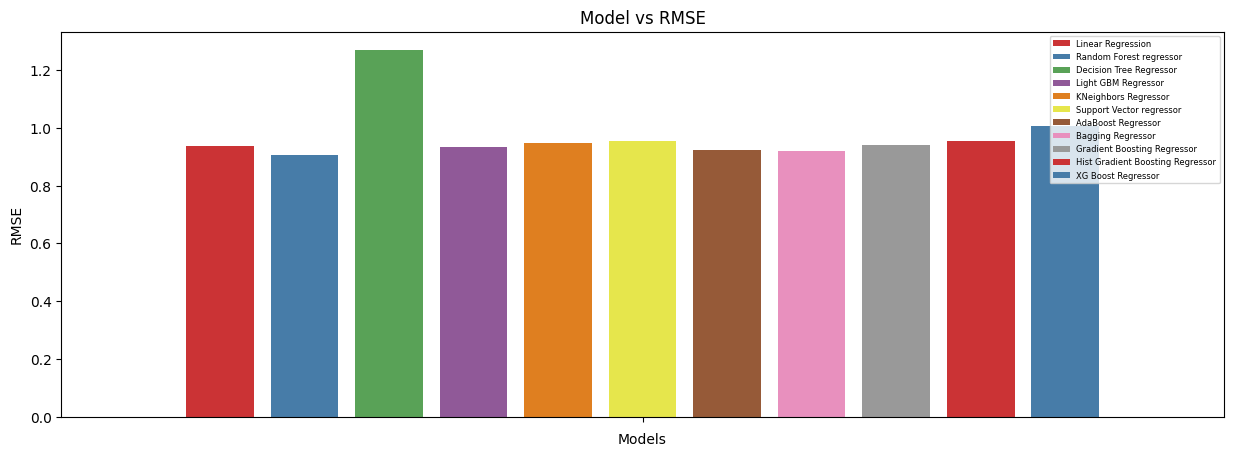

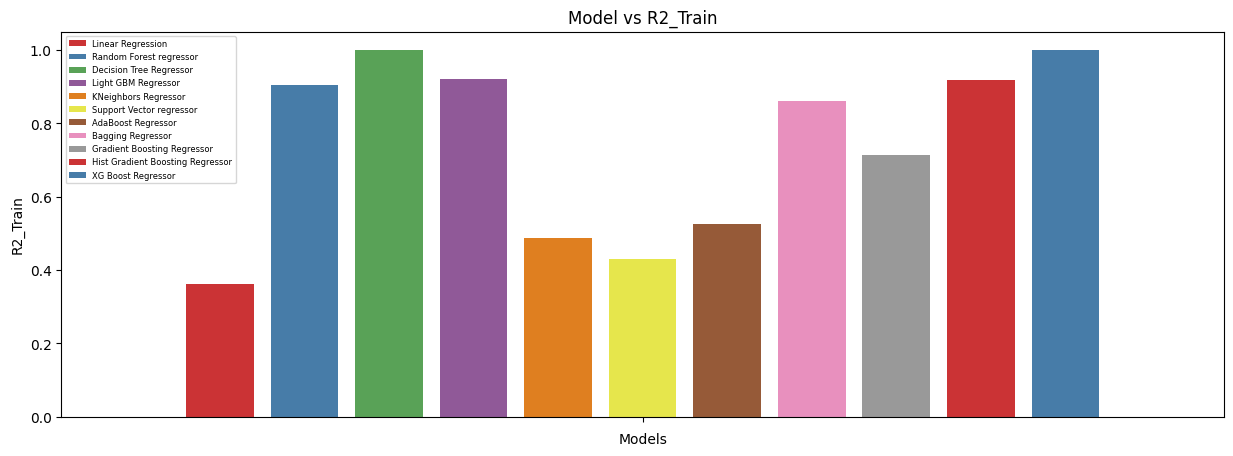

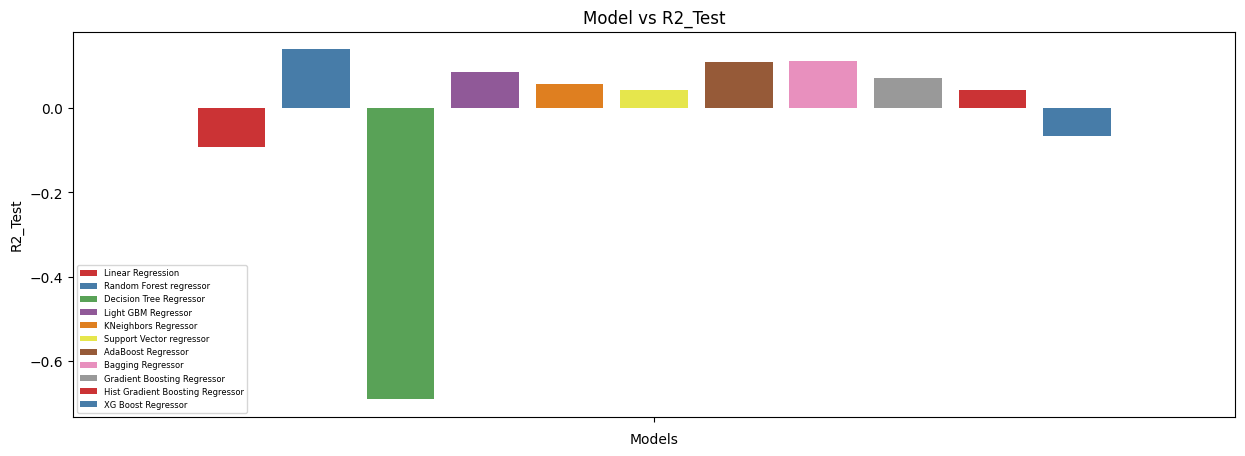

                               Model  R2_Train   R2_Test      RMSE
0                  Linear Regression  0.362242 -0.092560  0.935894
1            Random Forest regressor  0.905242  0.139804  0.904952
2            Decision Tree Regressor  1.000000 -0.690493  1.268627
3                Light GBM Regressor  0.919749  0.086589  0.932525
4               KNeighbors Regressor  0.488432  0.057191  0.947412
5           Support Vector regressor  0.429656  0.041964  0.955032
6                 AdaBoost Regressor  0.525315  0.108559  0.921242
7                  Bagging Regressor  0.861372  0.111494  0.919724
8        Gradient Boosting Regressor  0.713168  0.071091  0.940402
9   Hist Gradient Boosting Regressor  0.918317  0.043649  0.954192
10                XG Boost Regressor  0.999827 -0.064908  1.006893


In [ ]:
# Metrics visualization

eval_metrics = pd.DataFrame(metrics)


for n,i in enumerate(['RMSE','R2_Train','R2_Test']) :
    plt.figure(figsize=(15,5))
    X = eval_metrics['Model']
    y = eval_metrics[i]

    sns.barplot(data=eval_metrics,hue='Model',y = i, palette='Set1',gap=0.2)
    plt.xticks(rotation=90,fontsize = 8)
    plt.title(f'Model vs {i}')
    plt.legend(fontsize=6)
    plt.xlabel('Models')
    plt.show()

print(eval_metrics)

# Recommondation
### Random Forest Regressor is recommonded.